Assignment 2: Evaluating regression models
---------------------------
Use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study. Use one of two response variables: (1) the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars. Employ at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, ridge regression, lasso regression, and elastic net. Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Python scikit-learn should be your primary environment for conducting this research. Note that it is not necessary to employ polynomial regression in this assignment.

Regarding the management problem, imagine that you are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management, and why?

Boston house prices dataset
---------------------------
The Boston Housing Study is a market response study of sorts, with the market being 506 census tracts in the Boston metropolitan area. The objective of the study was to examine the effect of air pollution on housing prices, controlling for the effects of other explanatory variables. The response variable is the median price of homes in the census track. 

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per 10,000 (USD)
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in 1000's (USD)

# Data preparation and initial inspection

In [1]:
# Import dependencies for analysis/data prep
import numpy as np
import pandas as pd
import os
from math import sqrt  # for root mean-squared error calculation
import itertools
from scipy import stats as st

# Modeling routines from Scikit Learn packages
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn import preprocessing  # feature transformations 
from sklearn.compose import ColumnTransformer   # for scaling particular features
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV

# Plotting
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
%matplotlib inline

In [2]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

In [3]:
# Read in Boston housing data to a pandas DataFrame
boston_input = pd.read_csv('boston.csv')

In [4]:
# Inspect first 5 rows of data
boston_input.head()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [5]:
# Drop neighborhood attribute
boston_input = boston_input.drop('neighborhood', 1)

In [6]:
# Check for missing values
boston_input.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rooms      0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
mv         0
dtype: int64

# Descriptive statistics and visualizations of original data

In [10]:
# Inspect data shape: 506 rows, 13 columns/features/variables/attributes
boston_input.shape

(506, 13)

**Table 1: Initial descriptive statistics on original data**

In [11]:
# Inspect data
boston_input.describe(include='all')

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


**Figure 1: Pair plot of feature relationships**

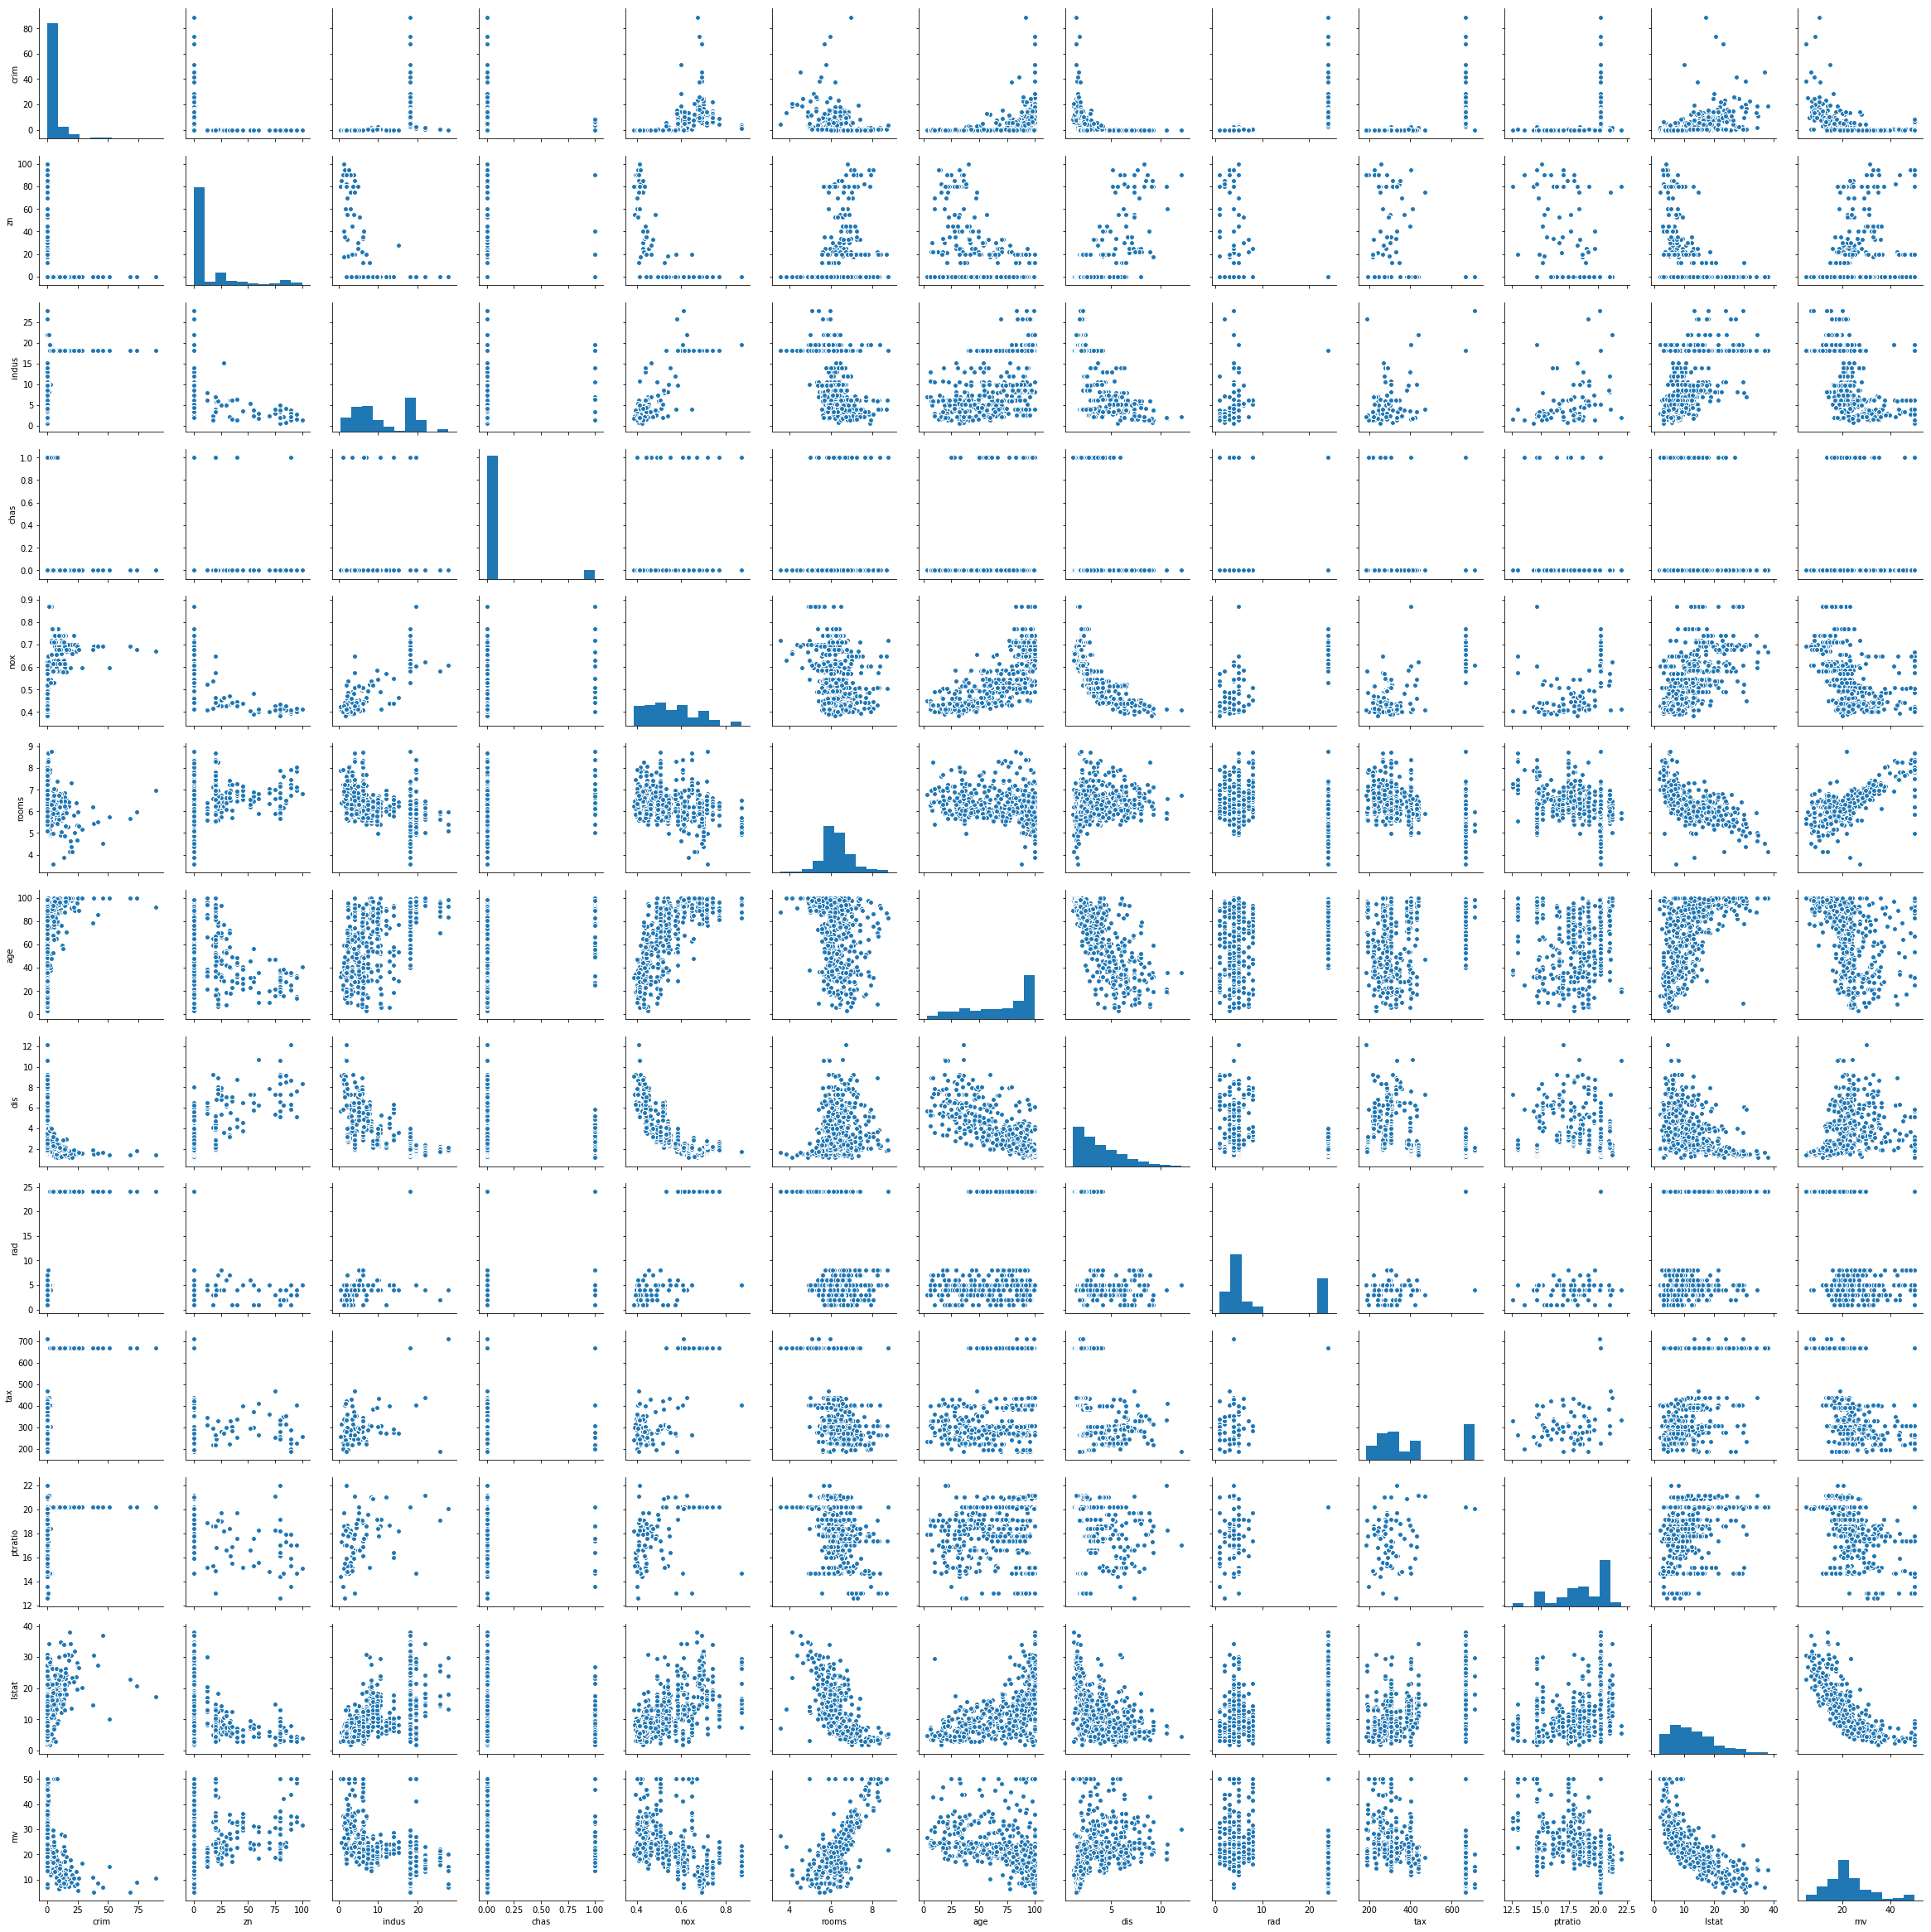

In [12]:
# Create pair plot for initial inspection of relationships
sns.pairplot(boston_input, diag_kind='hist')

# mv increases as the value of rooms increases 
# mv decreases with increase in lstat

**Figure 2: Box plots of original data**

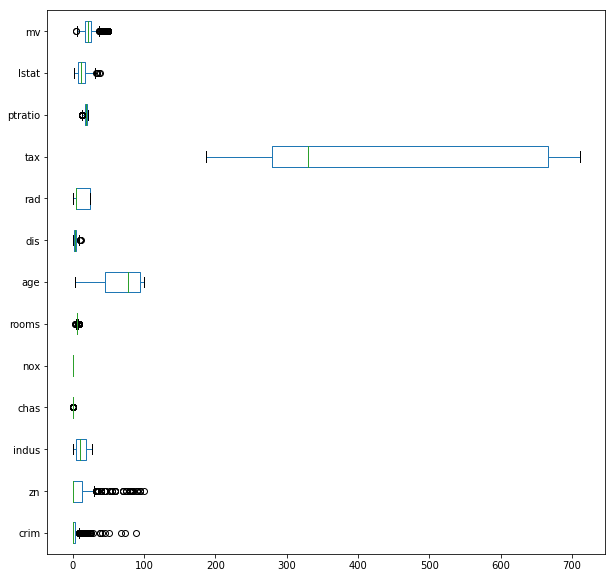

In [7]:
# Create boxplot of raw data to examine values, ranges, and measures of centrality
boston_input.boxplot(vert=False, figsize=(10,10), grid=False)

**Figure 3: Alternate box plots of original data**

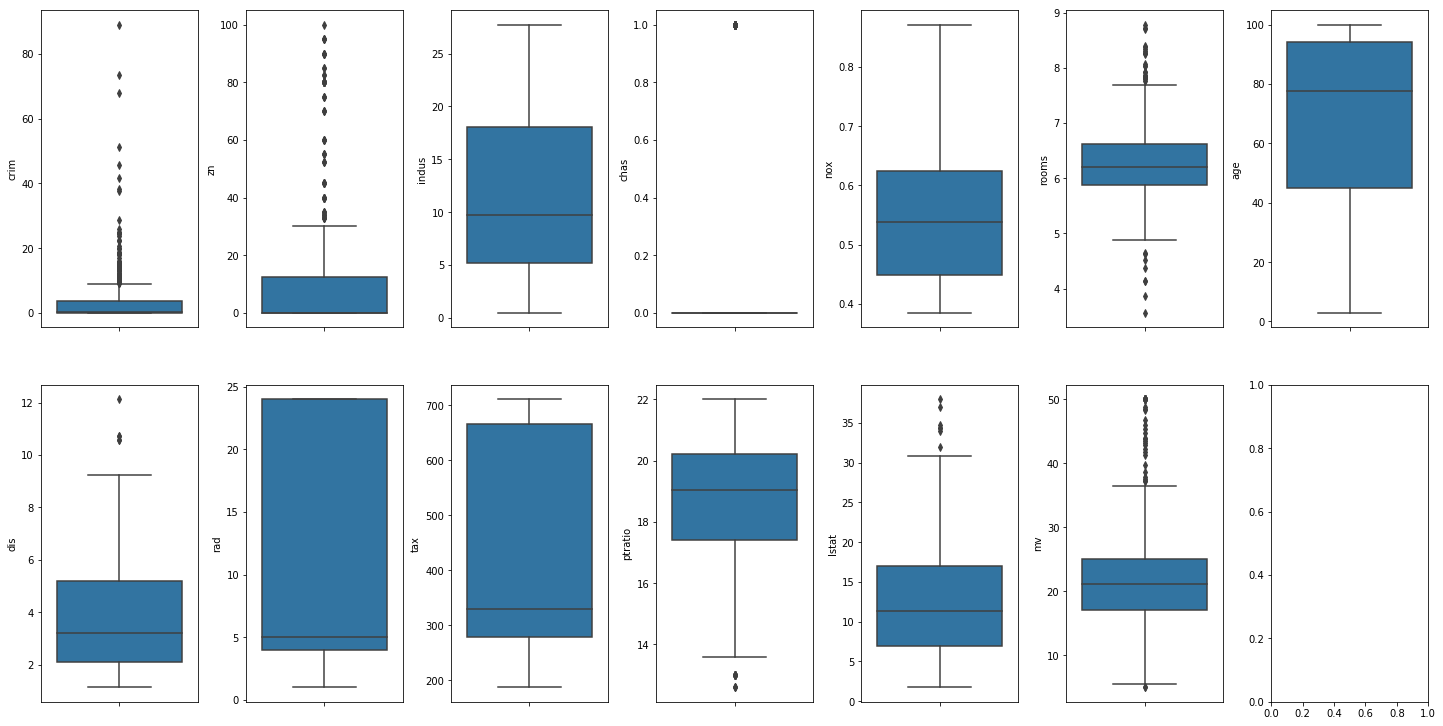

In [9]:
# Alternate look at features with boxplot
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in boston_input.items():
    sns.boxplot(y=k, data=boston_input, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

**Table 2: Outliers**

In [12]:
# Examine outliers for each feature
for k, v in boston_input.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(boston_input)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column crim outliers = 13.04%
Column zn outliers = 13.44%
Column indus outliers = 0.00%
Column chas outliers = 100.00%
Column nox outliers = 0.00%
Column rooms outliers = 5.93%
Column age outliers = 0.00%
Column dis outliers = 0.99%
Column rad outliers = 0.00%
Column tax outliers = 0.00%
Column ptratio outliers = 2.96%
Column lstat outliers = 1.38%
Column mv outliers = 7.71%


**Figure 4: Distributions of features**

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

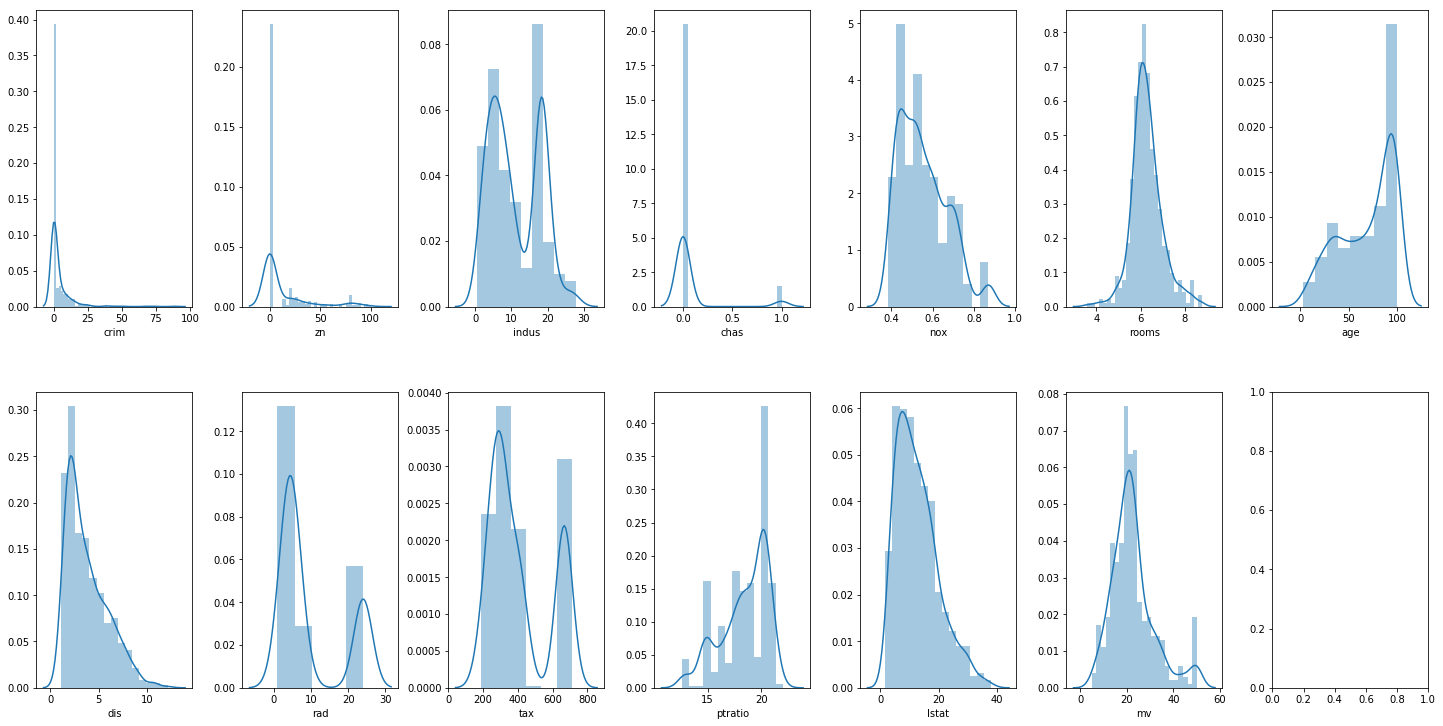

In [13]:
# Examine shape of distributions of features
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in boston_input.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# The histogram also shows that columns CRIM, ZN, B has highly skewed distributions. 
# Also MEDV looks to have a normal distribution (the predictions) and other colums seem to have 
# normal or bimodel ditribution of data except CHAS (which is a discrete variable).

**Figure 5: Distribution of median sale price (mv)**

<function matplotlib.pyplot.show(*args, **kw)>

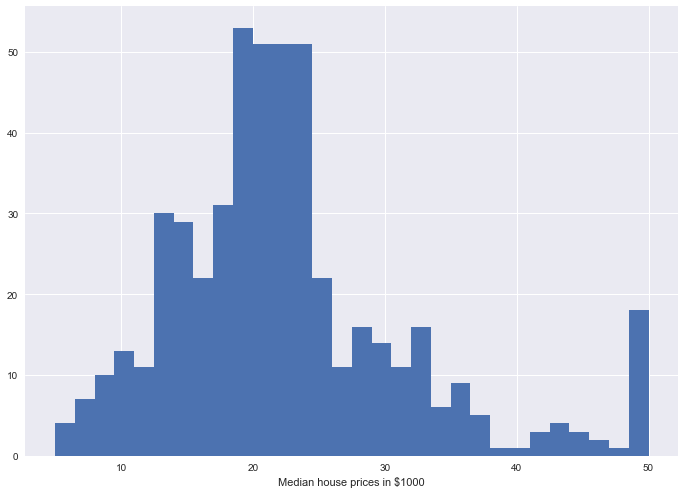

In [17]:
# Examine target variable (mv) specifically
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(boston_input['mv'], bins=30)
plt.xlabel("Median house prices in $1000")
plt.show

# Prices are distributed mostly normally, with a few outliers on the higher end
# Most houses are around the 20-24k range

**Figure 6: Correlation matrix for original data**

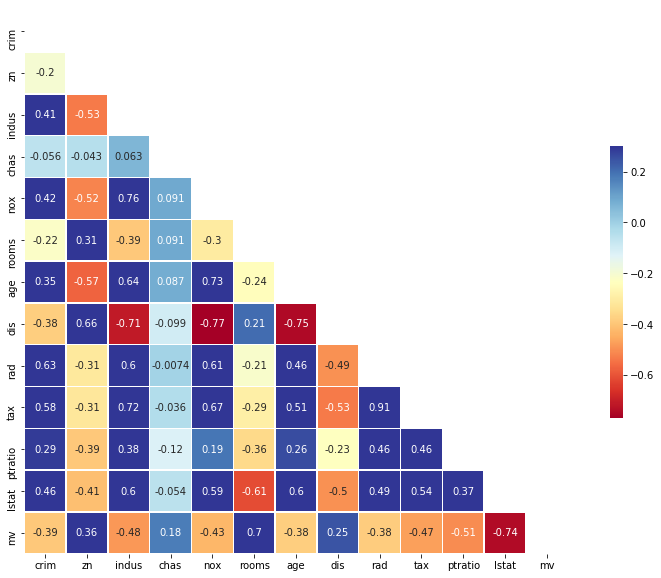

In [81]:
# Create correlation matrix for original data
plt.figure(figsize=(15,10))
corr = boston_input.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

# rm (average # of rooms per dwelling) has a strong positive correlation with mv (price) 
# lstat (% lower status of the population) has a strong negative correlation with mv

# Examine multicolinearity, where features have a strong correlation
# rad (index of accessibility to radial highways) and tax (full-value property-tax rate per $10000) 
# highly correlated
# dis (weighted distances to 5 Boston employment centers) and age (proportion of owner-occupied units built
# prior to 1940) highly correlated

# From correlation matrix, we see TAX and RAD are highly correlated features. 
# The columns LSTAT, INDUS, RM, TAX, NOX, PTRATIO has a correlation score above 0.5 with mv 
# which is a good indication of using as predictors. 


# Data transformation - log transformation of median value

In [7]:
# Log transform mv values
boston_log_mv = boston_input.copy()
boston_log_mv['mv'] = boston_input['mv'].apply(np.log)

In [8]:
# Inspect first 5 rows
boston_log_mv.head()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,3.178054
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,3.072693
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,3.546740
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,3.508556
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,3.589059


**Figure 7: MV versus MV log**

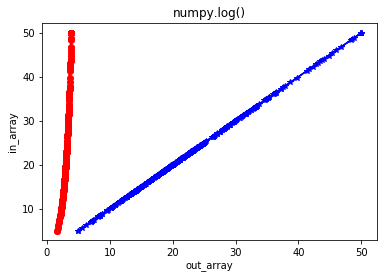

In [9]:
# Create plot for visual comparison
plt.plot(boston_input['mv'], boston_input['mv'],  
         color = 'blue', marker = "*") 
  
# Red for log transformed md, blue for original mv values
plt.plot(boston_log_mv['mv'], boston_input['mv'],  
         color = 'red', marker = "o") 

plt.title("numpy.log()") 
plt.xlabel("out_array") 
plt.ylabel("in_array") 
plt.show()

In [10]:
# Data prep
# Prepare transformed data and inspect 
cols_scaled = boston_log_mv.columns.tolist()
cols_scaled = cols_scaled[-1:] + cols_scaled[:-1]
boston_log_mv_model = boston_log_mv[cols_scaled]

# Inspect scaled data
boston_log_mv_model.describe(include='all')

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.034558,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063
std,0.408275,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062
min,1.609438,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000
25%,2.834680,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000
50%,3.054001,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000
75%,3.218876,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000
max,3.912023,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000


# Data transformation - standard scaler

In [48]:
# Create copy of the original DataFrame
boston_scaled_standard = boston_log_mv.copy()

# Scaling
col_names = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv']
features = boston_scaled_standard[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Assign result to columns
boston_scaled_standard[col_names] = features
print(boston_scaled_standard)

         crim        zn     indus      chas       nox     rooms       age  \
0   -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1   -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2   -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3   -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4   -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   
..        ...       ...       ...       ...       ...       ...       ...   
501 -0.413229 -0.487722  0.115738 -0.272599  0.158124  0.439316  0.018673   
502 -0.415249 -0.487722  0.115738 -0.272599  0.158124 -0.234548  0.288933   
503 -0.413447 -0.487722  0.115738 -0.272599  0.158124  0.984960  0.797449   
504 -0.407764 -0.487722  0.115738 -0.272599  0.158124  0.725672  0.736996   
505 -0.415000 -0.487722  0.115738 -0.272599  0.158124 -0.362767  0.434732   

          dis       rad       tax   ptratio     lstat        mv  
0    0.14

**Figure 8: Correlation matrix for standard scaled data**

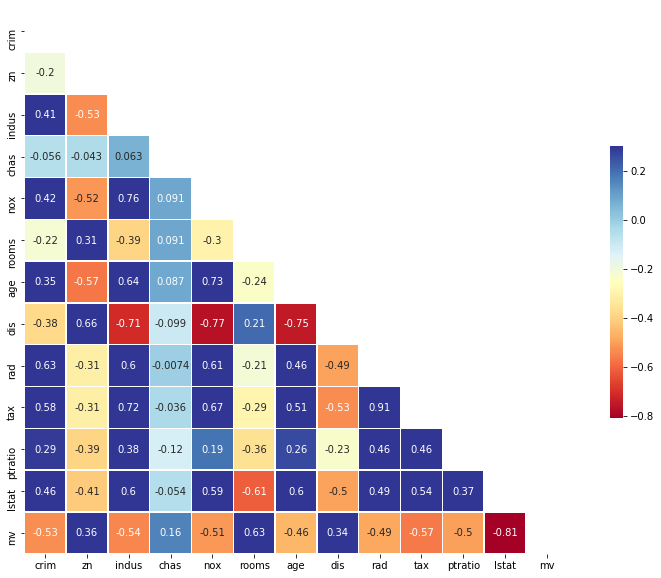

In [23]:
# Create correlation matrix for scaled data for comparison
plt.figure(figsize=(15,10))
corr = boston_scaled_standard.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

In [24]:
# Data prep
# Prepare scaled data and inspect 
cols_scaled = boston_scaled_standard.columns.tolist()
cols_scaled = cols_scaled[-1:] + cols_scaled[:-1]
boston_scaled_standard_model = boston_scaled_standard[cols_scaled]

# Inspect scaled data
boston_scaled_standard_model.describe(include='all')

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,-4.384942e-16,-8.688702e-17,3.306534e-16,2.804081e-16,-3.100287e-16,-8.071058e-16,-5.978968e-17,-2.650493e-16,8.293761e-17,1.514379e-15,-9.934960e-16,4.493551e-16,-1.595123e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00
min,-3.494045e+00,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990e+00,-2.707379e+00,-1.531127e+00
25%,-4.900528e-01,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-7.675760e-01,-4.880391e-01,-7.994200e-01
50%,4.766992e-02,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-4.646726e-01,2.748590e-01,-1.812536e-01
75%,4.519022e-01,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926e+00,8.065758e-01,6.030188e-01
max,2.151329e+00,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194e+00,1.638828e+00,3.548771e+00


# Data transformation - Min-Max scaler

In [49]:
# Create copy of the original DataFrame
boston_scaled_minmax = boston_log_mv.copy()

# Scaling
col_names = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv']
features = boston_scaled_minmax[col_names]
scaler = preprocessing.MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

# Assign result to columns
boston_scaled_minmax[col_names] = features
print(boston_scaled_minmax)

         crim    zn     indus  chas       nox     rooms       age       dis  \
0    0.000000  0.18  0.067815   0.0  0.314815  0.577505  0.641607  0.269203   
1    0.000236  0.00  0.242302   0.0  0.172840  0.547998  0.782698  0.348962   
2    0.000236  0.00  0.242302   0.0  0.172840  0.694386  0.599382  0.348962   
3    0.000293  0.00  0.063050   0.0  0.150206  0.658555  0.441813  0.448545   
4    0.000705  0.00  0.063050   0.0  0.150206  0.687105  0.528321  0.448545   
..        ...   ...       ...   ...       ...       ...       ...       ...   
501  0.000633  0.00  0.420455   0.0  0.386831  0.580954  0.681771  0.122671   
502  0.000438  0.00  0.420455   0.0  0.386831  0.490324  0.760041  0.105293   
503  0.000612  0.00  0.420455   0.0  0.386831  0.654340  0.907312  0.094381   
504  0.001161  0.00  0.420455   0.0  0.386831  0.619467  0.889804  0.114514   
505  0.000462  0.00  0.420455   0.0  0.386831  0.473079  0.802266  0.125072   

          rad       tax   ptratio     lstat        

**Figure 9: Correlation matrix for min-max scaled data**

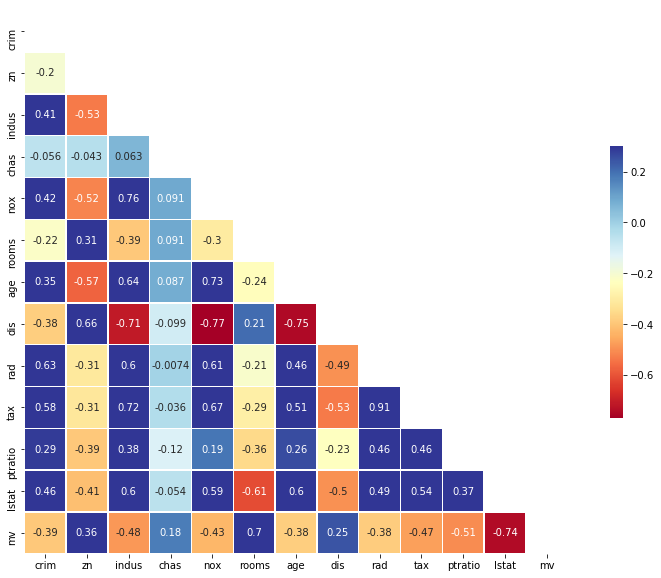

In [19]:
# Create correlation matrix for scaled data for comparison
plt.figure(figsize=(15,10))
corr = boston_scaled_minmax.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

In [20]:
# Data prep
# Prepare scaled data and inspect 
cols_scaled = boston_scaled_minmax.columns.tolist()
cols_scaled = cols_scaled[-1:] + cols_scaled[:-1]
boston_scaled_minmax_model = boston_scaled_minmax[cols_scaled]

# Inspect scaled data
boston_scaled_minmax_model.describe(include='all')

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.618922,0.040544,0.113636,0.391378,0.069170,0.349167,0.521869,0.676364,0.242381,0.371713,0.422208,0.622929,0.301409
std,0.177311,0.096679,0.233225,0.251479,0.253994,0.238431,0.134627,0.289896,0.191482,0.378576,0.321636,0.230313,0.197049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.532116,0.000851,0.000000,0.173387,0.000000,0.131687,0.445392,0.433831,0.088259,0.130435,0.175573,0.510638,0.144040
50%,0.627366,0.002812,0.000000,0.338343,0.000000,0.314815,0.507281,0.768280,0.188949,0.173913,0.272901,0.686170,0.265728
75%,0.698970,0.041258,0.125000,0.646628,0.000000,0.491770,0.586798,0.938980,0.369088,1.000000,0.914122,0.808511,0.420116
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data transformation - Box Cox transformation

In [50]:
# Data transformations and inspection

# Apply transformation
boston_input2 = boston_input.apply(lambda x: x+.01)

# Inspect first 5 rows of transformed dataset
boston_input2.head()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.01632,18.01,2.32,0.01,0.548,6.585,65.21,4.1000,1.01,296.01,15.31,4.99,24.01
1,0.03731,0.01,7.08,0.01,0.479,6.431,78.91,4.9771,2.01,242.01,17.81,9.15,21.61
2,0.03729,0.01,7.08,0.01,0.479,7.195,61.11,4.9771,2.01,242.01,17.81,4.04,34.71
3,0.04237,0.01,2.19,0.01,0.468,7.008,45.81,6.0722,3.01,222.01,18.71,2.95,33.41
4,0.07905,0.01,2.19,0.01,0.468,7.157,54.21,6.0722,3.01,222.01,18.71,5.34,36.21


**Figure 10: Pair plot of Box Cox transformed features**

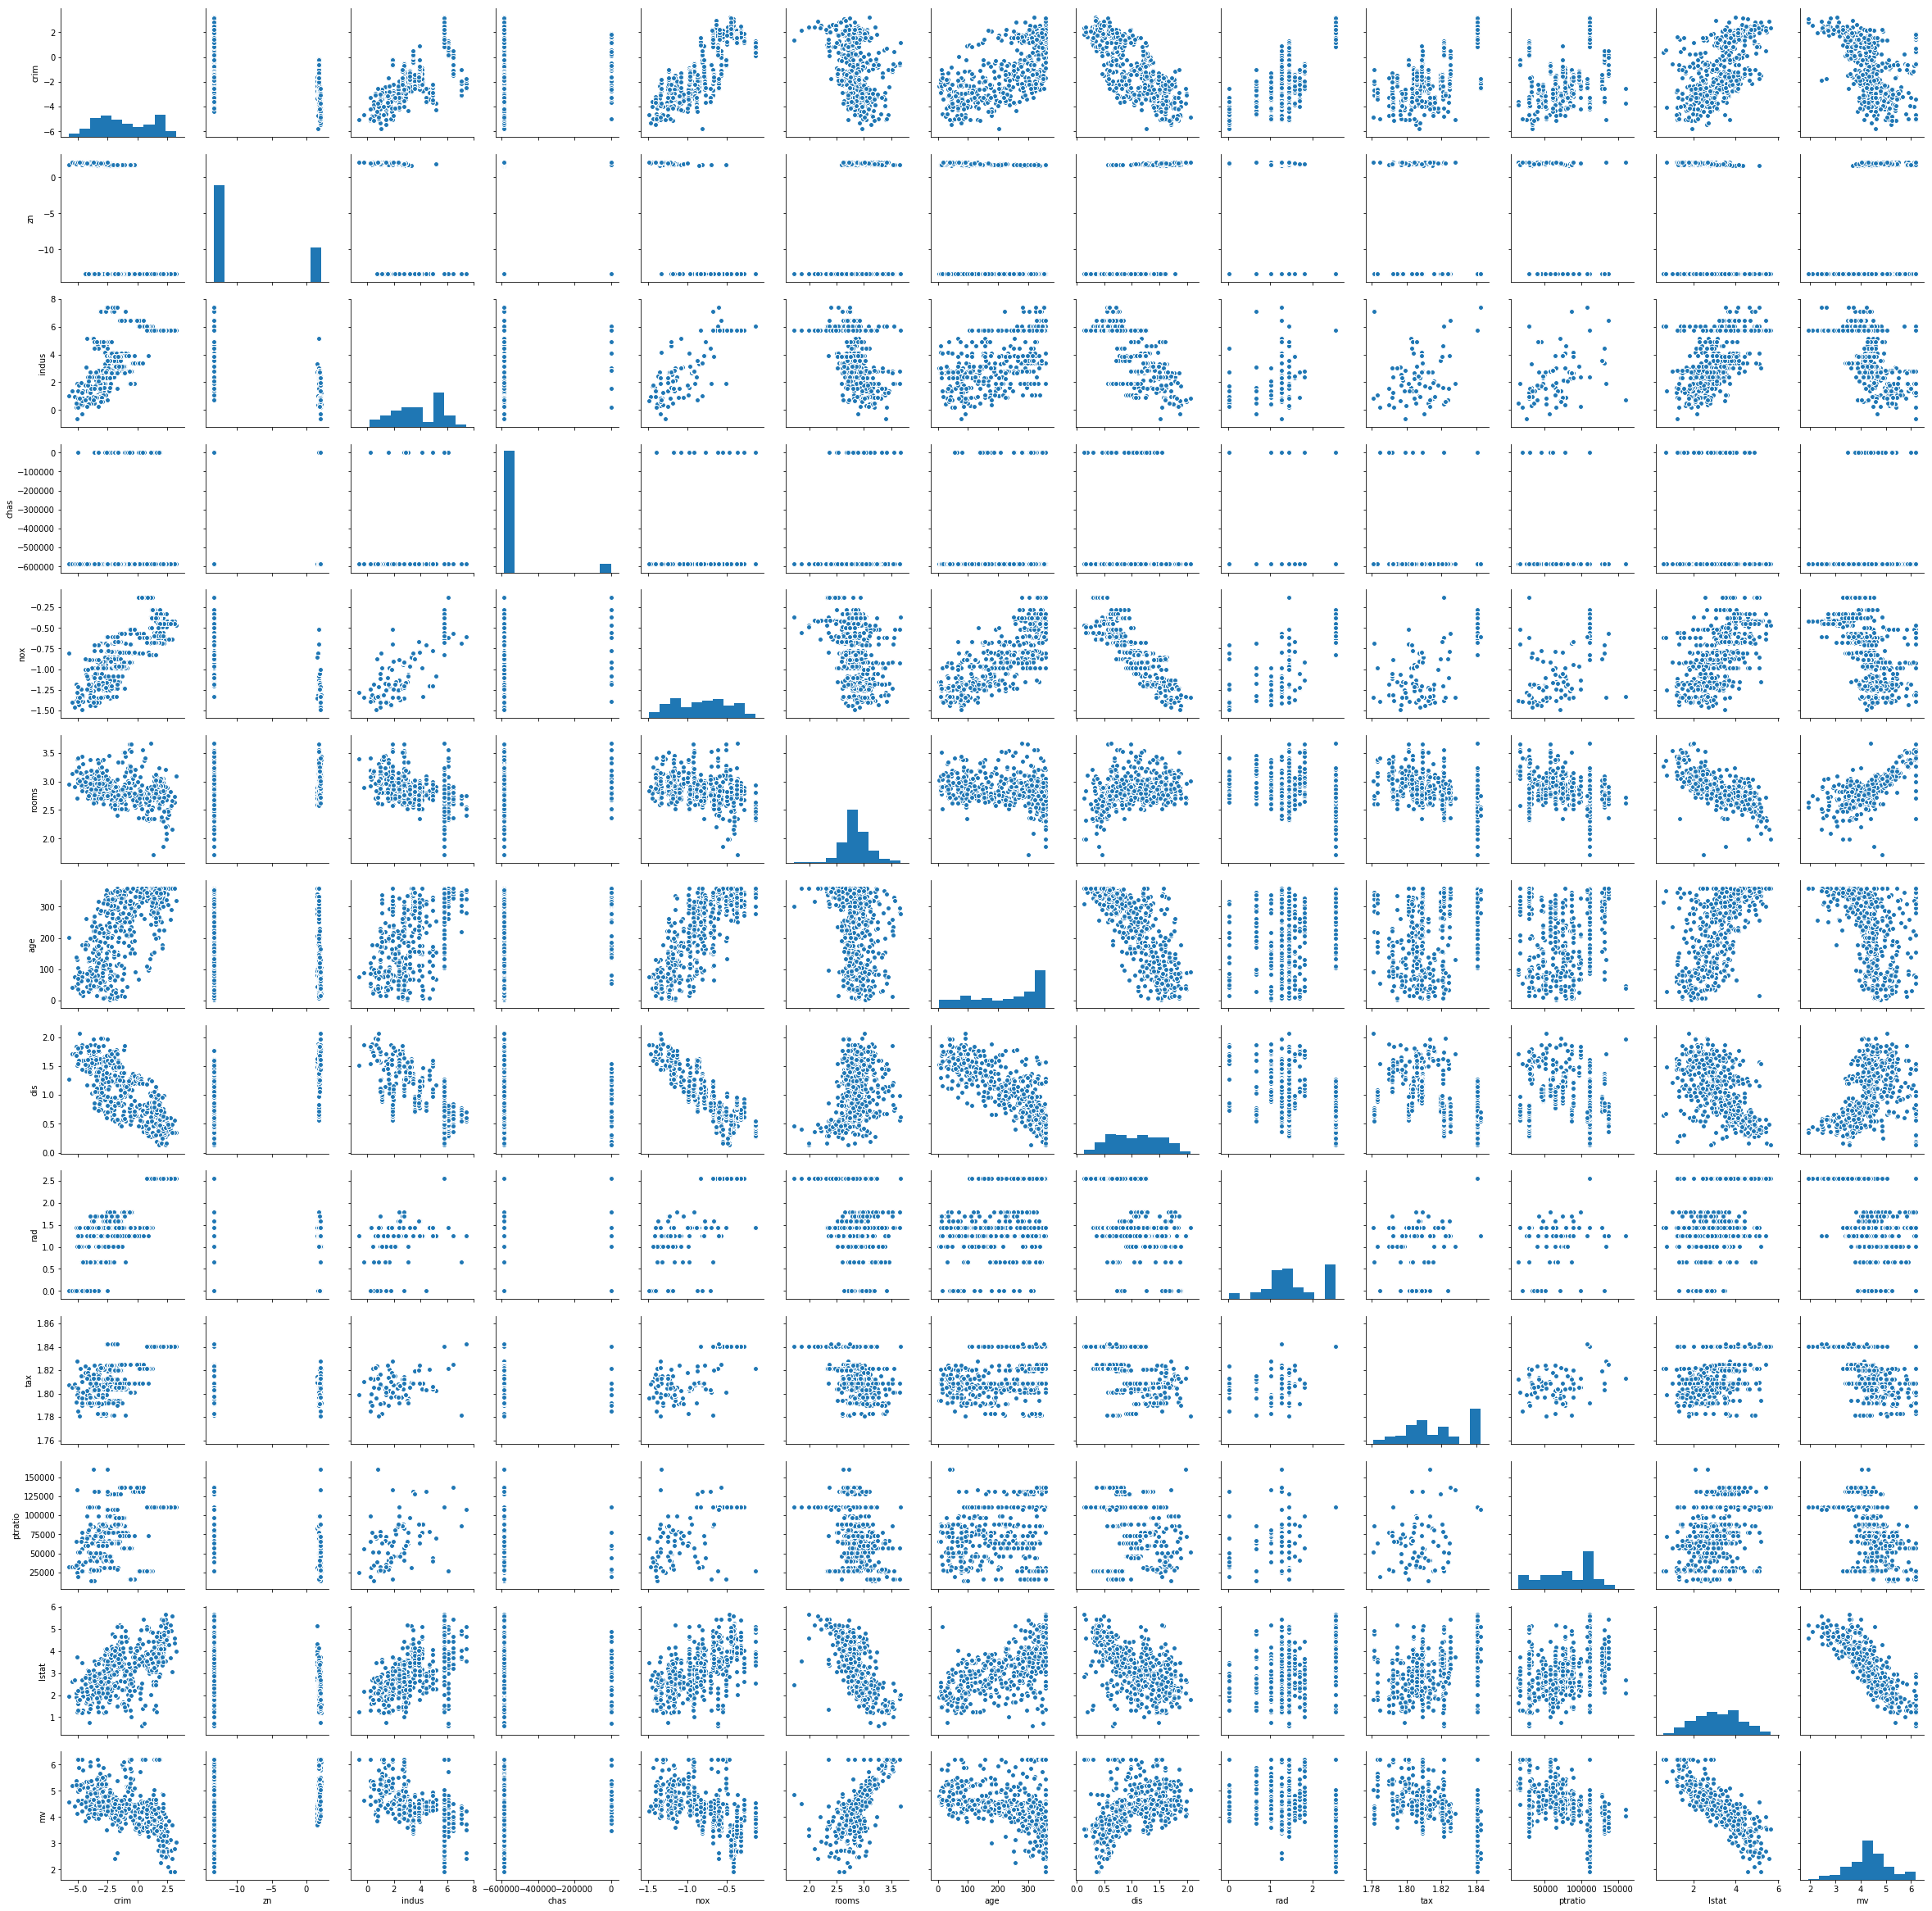

In [51]:
# Box Cox transformation
boston_input3 = boston_input2.apply(lambda x: st.boxcox(x)[0])

# Inspect first 5 rows of transformed dataset
boston_input3.head()

# Visualize relationships again with pair plots
sns.pairplot(boston_input3, diag_kind='hist')

**Figure 11: Histogram of distributions of Box Cox transformed features**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c9d9940>,
      dtype=object)

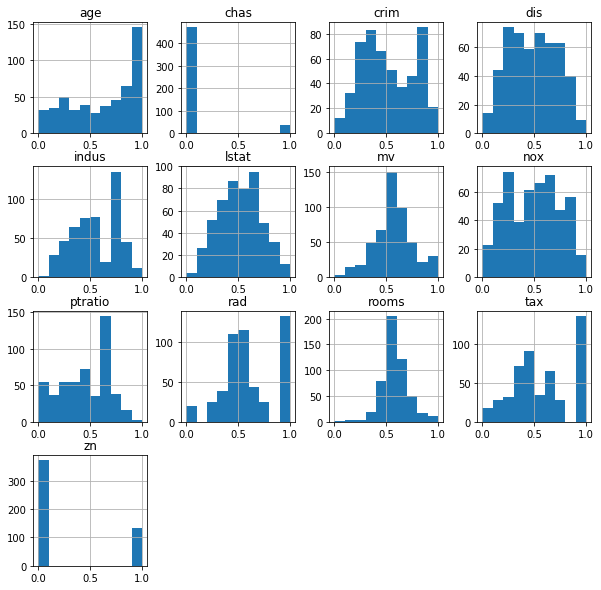

In [35]:
# Scale predictors using normalization 
boston_input4 = boston_input3.transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Create pair plots of scaled data to examine attribute relationships again
boston_input4.hist(figsize=(10,10))

**Figure 12: Correlation matrix for Box Cox transformed data**

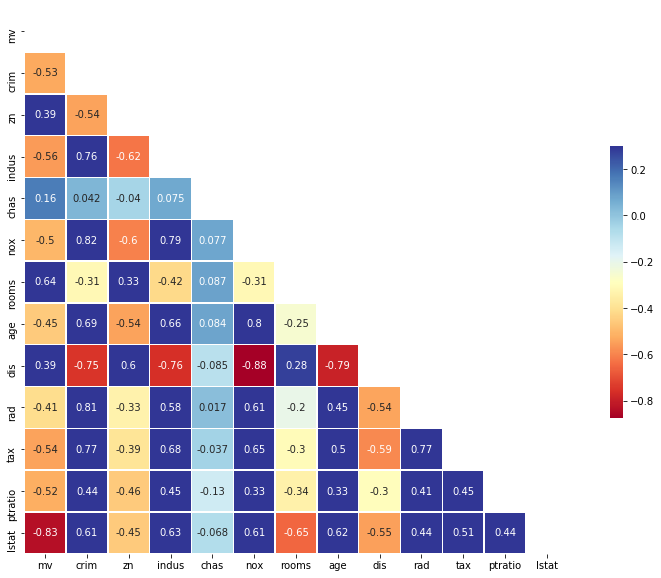

In [37]:
# Create correlation matrix for scaled data
plt.figure(figsize=(15,10))
corr = boston_input_boxcox.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

In [31]:
# Data prep
# Prepare scaled data and inspect 
cols_scaled = boston_input_boxcox.columns.tolist()
# cols_scaled = cols_scaled[:-1] + cols_scaled[:-1]
# cols_scaled = cols_scaled[:-1] + cols_scaled[:-1]
boston_boxcox_model = boston_input_boxcox[cols_scaled]

# Inspect scaled data
boston_boxcox_model.describe(include='all')

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.566816,0.518606,0.261061,0.562812,0.069170,0.490420,0.577607,0.625279,0.485270,0.625027,0.581265,0.461663,0.517794
std,0.184926,0.247164,0.435430,0.232825,0.253994,0.251621,0.129442,0.315506,0.229684,0.260145,0.280933,0.236275,0.200937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.469326,0.319026,0.000000,0.378568,0.000000,0.249073,0.506588,0.337094,0.297601,0.491579,0.375989,0.298320,0.364902
50%,0.567460,0.476717,0.000000,0.559586,0.000000,0.500909,0.567485,0.707846,0.485207,0.562195,0.511675,0.489371,0.524193
75%,0.644398,0.771394,0.967068,0.796857,0.000000,0.678615,0.643218,0.920638,0.683853,1.000000,0.965644,0.659680,0.667866
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model setup
Data subsets:<br>
Standard scaled: boston_scaled_standard_model<br>
MinMax scaled: boston_scaled_minmax_model<br>
Boxcox transformed: boston_boxcox_model<br>

In [56]:
# Seed value for random number generator to obtain reproducible results
RANDOM_SEED = 1

Original hyperparameters used

In [69]:
# Model method calls preparation
names = ['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression', 'ElasticNet_Regression', 
        'RandomForest_Regression', 'ExtraTrees_Regression']

# Specify set of regression models to evaluate
# Set normal=False because data was already transformed
regressors = [LinearRegression(fit_intercept = True, normalize = False),
             Ridge(alpha=75, solver='auto', fit_intercept=True, normalize=False, 
                   random_state = RANDOM_SEED),
             Lasso(alpha=0.01, max_iter=10000, tol=0.01, fit_intercept=True, normalize=False, 
                   random_state=RANDOM_SEED),
             ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, tol=0.01, fit_intercept=True, 
                        normalize=False, random_state=RANDOM_SEED),
             RandomForestRegressor(n_estimators=10, criterion='mse', max_features=10, bootstrap=True, 
                                   n_jobs=-1, random_state=RANDOM_SEED),
             ExtraTreesRegressor(n_estimators=100, criterion='mse', max_features=10, bootstrap=True, 
                                   n_jobs=-1, random_state=RANDOM_SEED)]

Hyperparameters used for fine-tuning with grid search

In [72]:
# Model method calls preparation with adjusted hyperparameters for Random Forest and Extra Trees Regression methods
names = ['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression', 'ElasticNet_Regression', 
        'RandomForest_Regression', 'ExtraTrees_Regression']

# Specify set of regression models to evaluate
# Set normal=False because data was already transformed
regressors = [LinearRegression(fit_intercept = True, normalize = False),
             Ridge(alpha=100, solver='auto', fit_intercept=True, normalize=False, 
                   random_state = RANDOM_SEED),
             Lasso(alpha=0.1, max_iter=10000, tol=0.01, fit_intercept=True, normalize=False, 
                   random_state=RANDOM_SEED),
             ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, tol=0.01, fit_intercept=True, 
                        normalize=False, random_state=RANDOM_SEED),
             RandomForestRegressor(n_estimators=100, criterion='mse', max_features=6, bootstrap=True, 
                                   n_jobs=-1, random_state=RANDOM_SEED),
             ExtraTreesRegressor(n_estimators=100, criterion='mse', max_features=10, bootstrap=False, 
                                   n_jobs=-1, random_state=RANDOM_SEED)]

Approach 1: Model evaluation with cross-validation design
----------------------
- Log transformation of median sale price values
- Standard scaler

In [70]:
# Define model data
model_data = boston_scaled_standard_model.values

In [71]:
# Define number of cross folds to employ
N_FOLDS = 10

# Set up numpy array to store results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
# kf = KFold(n_splits=N_FOLDS, shuffle=False, random_state=RANDOM_SEED)
# Trying shuffle=True
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Check splitting process by looking at fold observation counts
index_for_fold = 0    # Fold count initiated
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '--------------------------')
    
# Data modeling structure places response variable first and predictor variables following
# 1:model_data.shape[1] slices for predictor variables and 0 is the response variable index
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]
    
    index_for_method = 0    # Initialize method cound
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)    # Fit on the train set for this fold
        
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1
    
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')
print(cv_results_df.mean())


Fold index: 0 --------------------------

Fold index: 1 --------------------------

Fold index: 2 --------------------------

Fold index: 3 --------------------------

Fold index: 4 --------------------------

Fold index: 5 --------------------------

Fold index: 6 --------------------------

Fold index: 7 --------------------------

Fold index: 8 --------------------------

Fold index: 9 --------------------------

----------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.469137
Ridge_Regression           0.481631
Lasso_Regression           0.471980
ElasticNet_Regression      0.469064
RandomForest_Regression    0.381288
ExtraTrees_Regression      0.340040
dtype: float64


Approach 2: Model evaluation with cross-validation design
----------------------
- Log transformation of median sale price values
- Min-Max scaler

In [73]:
# Define model data
model_data = boston_scaled_minmax_model.values

In [74]:
# Define number of cross folds to employ
N_FOLDS = 10

# Set up numpy array to store results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
# kf = KFold(n_splits=N_FOLDS, shuffle=False, random_state=RANDOM_SEED)
# Trying shuffle=True
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Check splitting process by looking at fold observation counts
index_for_fold = 0    # Fold count initiated
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '--------------------------')
    
# Data modeling structure places response variable first and predictor variables following
# 1:model_data.shape[1] slices for predictor variables and 0 is the response variable index
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]
    
    index_for_method = 0    # Initialize method cound
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)    # Fit on the train set for this fold
        
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1
    
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')
print(cv_results_df.mean())


Fold index: 0 --------------------------

Fold index: 1 --------------------------

Fold index: 2 --------------------------

Fold index: 3 --------------------------

Fold index: 4 --------------------------

Fold index: 5 --------------------------

Fold index: 6 --------------------------

Fold index: 7 --------------------------

Fold index: 8 --------------------------

Fold index: 9 --------------------------

----------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.083101
Ridge_Regression           0.131132
Lasso_Regression           0.176941
ElasticNet_Regression      0.176941
RandomForest_Regression    0.062065
ExtraTrees_Regression      0.058273
dtype: float64


Approach 3: Model evaluation with cross-validation design
----------------------
- Log transformation of median sale price values
- Box Cox transformation

In [62]:
# Define model data
model_data = boston_boxcox_model.values

In [63]:
# Define number of cross folds to employ
N_FOLDS = 10

# Set up numpy array to store results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
# kf = KFold(n_splits=N_FOLDS, shuffle=False, random_state=RANDOM_SEED)
# Trying shuffle=True
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Check splitting process by looking at fold observation counts
index_for_fold = 0    # Fold count initiated
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '--------------------------')
    
# Data modeling structure places response variable first and predictor variables following
# 1:model_data.shape[1] slices for predictor variables and 0 is the response variable index
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]
    
    index_for_method = 0    # Initialize method cound
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)    # Fit on the train set for this fold
        
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1
    
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')
print(cv_results_df.mean())


Fold index: 0 --------------------------

Fold index: 1 --------------------------

Fold index: 2 --------------------------

Fold index: 3 --------------------------

Fold index: 4 --------------------------

Fold index: 5 --------------------------

Fold index: 6 --------------------------

Fold index: 7 --------------------------

Fold index: 8 --------------------------

Fold index: 9 --------------------------

----------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.088855
Ridge_Regression           0.133030
Lasso_Regression           0.110640
ElasticNet_Regression      0.102586
RandomForest_Regression    0.066975
ExtraTrees_Regression      0.061154
dtype: float64


In [ ]:
# Results across all three approaches
Log transformed mv, standard scaler:
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.469137
Ridge_Regression           0.481631
Lasso_Regression           0.471980
ElasticNet_Regression      0.469064
RandomForest_Regression    0.381288
ExtraTrees_Regression      0.340040

Log transformed mv, minmax scaler:
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Linear_Regression          0.083101
Ridge_Regression           0.126469
Lasso_Regression           0.112074
ElasticNet_Regression      0.101857
RandomForest_Regression    0.066119
ExtraTrees_Regression      0.059416

Linear_Regression          0.083101
Ridge_Regression           0.131132
Lasso_Regression           0.176941
ElasticNet_Regression      0.176941
RandomForest_Regression    0.062065
ExtraTrees_Regression      0.058273

Log transformed mv, boxcox scaler:
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.088855
Ridge_Regression           0.133030
Lasso_Regression           0.110640
ElasticNet_Regression      0.102586
RandomForest_Regression    0.063525
ExtraTrees_Regression      0.061154

# Modeling technique comparison

In [64]:
# Comparison of RMSE values across 3 approaches
# initialize list of lists 
data = {'Method':['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'ExtraTrees'], 'RMSE1': 
        [0.469137, 0.481631, 0.471980, 0.469064, 0.381288, 0.340040], 'RMSE2': [0.083101, 0.126469, 0.112074, 
                                                                                0.101857, 0.066119, 0.059416], 
        'RMSE3': [0.088855, 0.133030, 0.110640, 0.102586, 0.063525, 0.061154]}
  
# Create the pandas DataFrame 
approach_df = pd.DataFrame(data, columns = ['Method', 'RMSE1', 'RMSE2', 'RMSE3']) 
  
# Print results
approach_df 

,Method,RMSE1,RMSE2,RMSE3
0,Linear,0.469137,0.083101,0.088855
1,Ridge,0.481631,0.126469,0.133030
2,Lasso,0.471980,0.112074,0.110640
3,ElasticNet,0.469064,0.101857,0.102586
4,RandomForest,0.381288,0.066119,0.063525
5,ExtraTrees,0.340040,0.059416,0.061154


Approaches 2 and 3 have relatively close RMSE values for each modeling method and are lower than approach 1's values. Random Forest and Extra Trees Regression have the best performance for this data and learning approach.

# Model fine-tuning 
## Grid search - Random Forest Regression

In [129]:
# Grid search with Approach 2: Log transformation of median sale price values and MinMax scaler

param_grid = [
    {'n_estimators': [3, 10, 30, 60, 100, 150], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 60, 100, 150], 'max_features': [2, 3, 4, 6, 8, 10]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [130]:
# Display parameter recommendations
grid_search.best_params_

{'max_features': 6, 'n_estimators': 100}

### Fit model again with parameter adjustments for max features and number of estimators
Original: RandomForest_Regression 0.066119	
With adjusted hyperparameters: RandomForest_Regression    0.062065

# Model fine-tuning 
## Grid search - Extra Trees Regression

In [135]:
# Grid search with Approach 2: Log transformation of median sale price values and MinMax scaler

param_grid = [
    {'n_estimators': [3, 10, 30, 60, 100, 150], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 60, 100, 150], 'max_features': [2, 3, 4, 6, 8, 10]},
  ]

extratrees_reg = ExtraTreesRegressor()

grid_search = GridSearchCV(extratrees_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             par

In [136]:
# Display parameter recommendations
grid_search.best_params_

{'bootstrap': False, 'max_features': 10, 'n_estimators': 100}

### Fit model again with parameter adjustments for max features and number of estimators
Original ExtraTrees_Regression      0.059416<br>
With adjusted hyperparameters: ExtraTrees_Regression      0.058273

# Final model evaluation results
Extra Trees Regression with hyperparameters tuned using Grid Search resulted in the lowest RMSE score with log-transformed median sale price (dependent features) and Min-Max scaled independent features.

# Visualizations

For comparison of actual versus predicted values for median sale price, a scatterplot for each method provides a visual comparison of the methods' predictive capability for the dataset as is.  

Use actual values (x axis) = X_test[:,-1]<br>
Use predicted values (y axis)

**Figure 13: Linear regression on min-max scaled data: actual versus predicted values**

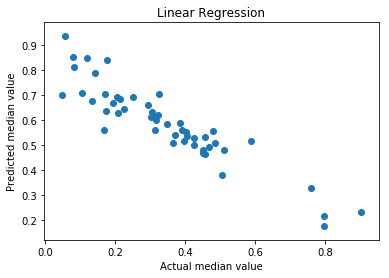

In [63]:
# Linear Regression: Approach 2

# Step 1: fit model
lr = LinearRegression(fit_intercept = True, normalize = False).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_lr = lr.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_lr)
plt.title("Linear Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 14: Linear regression on Box Cox transformed data: actual versus predicted values**

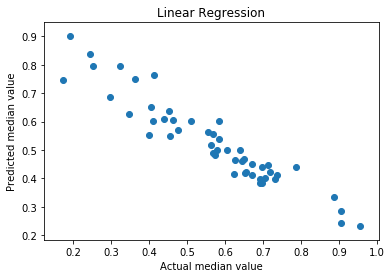

In [66]:
# Linear Regression: Approach 3

# Step 1: fit model
lr = LinearRegression(fit_intercept = True, normalize = False).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_lr = lr.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_lr)
plt.title("Linear Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 15: Ridge regression on min-max scaled data: actual versus predicted values**

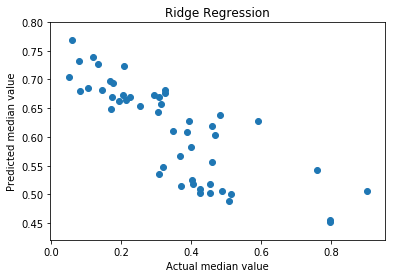

In [69]:
# Ridge Regression - Approach 2

# Step 1: fit model
ridge = Ridge(alpha=75, solver='cholesky', fit_intercept=True, normalize=False, 
                   random_state = RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_ridge = ridge.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_ridge)
plt.title("Ridge Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 16: Ridge regression on Box Cox scaled data: actual versus predicted values**

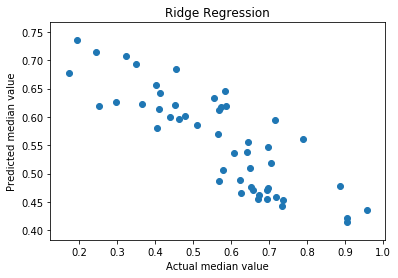

In [76]:
# Ridge Regression - Approach 3

# Step 1: fit model
ridge = Ridge(alpha=75, solver='cholesky', fit_intercept=True, normalize=False, 
                   random_state = RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_ridge = ridge.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_ridge)
plt.title("Ridge Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 17: Lasso regression on min-max scaled data: actual versus predicted values**

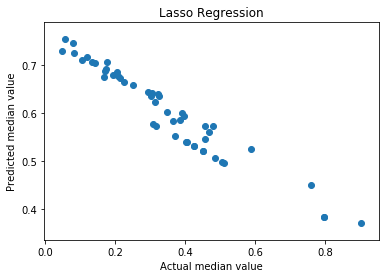

In [70]:
# Lasso Regression - Approach 2

# Step 1: fit model
lasso = Lasso(alpha=0.01, max_iter=10000, tol=0.01, fit_intercept=True, normalize=False, 
                   random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_lasso = lasso.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_lasso)
plt.title("Lasso Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 18: Lasso regression on Box Cox scaled data: actual versus predicted values**

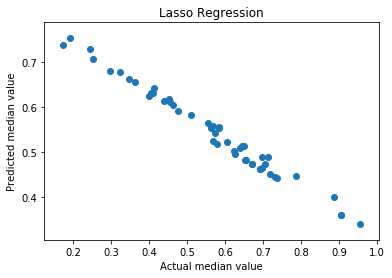

In [77]:
# Lasso Regression - Approach 3

# Step 1: fit model
lasso = Lasso(alpha=0.01, max_iter=10000, tol=0.01, fit_intercept=True, normalize=False, 
                   random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_lasso = lasso.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_lasso)
plt.title("Lasso Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 19: ElasticNet regression on min-max scaled data: actual versus predicted values**

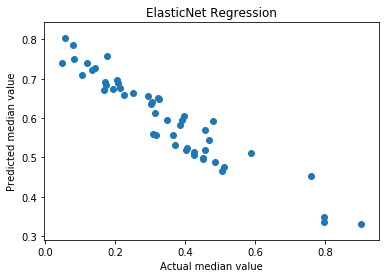

In [71]:
# ElasticNet - Approach 2

# Step 1: fit model
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, tol=0.01, fit_intercept=True, 
             normalize=False, random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_elasticnet = elasticnet.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_elasticnet)
plt.title("ElasticNet Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 20: ElasticNet regression on Box Cox scaled data: actual versus predicted values**

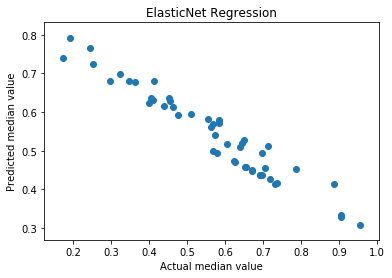

In [78]:
# ElasticNet - Approach 3

# Step 1: fit model
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, tol=0.01, fit_intercept=True, 
             normalize=False, random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_elasticnet = elasticnet.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_elasticnet)
plt.title("ElasticNet Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 21: Random Forest regression on min-max scaled data: actual versus predicted values**

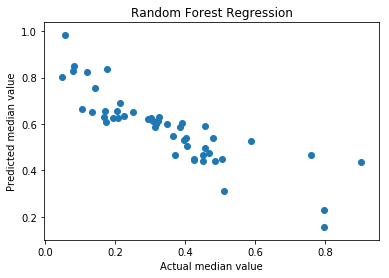

In [145]:
# Random Forest Regressor - Approach 2

# Step 1: fit model
randomforest = RandomForestRegressor(n_estimators=100, criterion='mse', max_features=6, bootstrap=True, 
                                     n_jobs=-1, random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_randomforest = randomforest.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_randomforest)
plt.title("Random Forest Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 22: Random Forest regression on Box Cox scaled data: actual versus predicted values**

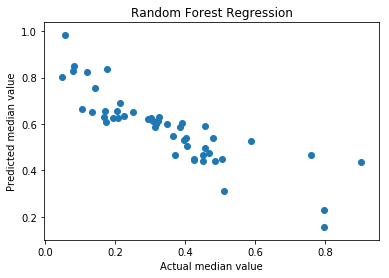

In [148]:
# # Random Forest Regressor - Approach 3

# Step 1: fit model
randomforest = RandomForestRegressor(n_estimators=100, criterion='mse', max_features=6, bootstrap=True, 
                                     n_jobs=-1, random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_randomforest = randomforest.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_randomforest)
plt.title("Random Forest Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 23: Extra Trees regression on min-max scaled data: actual versus predicted values**

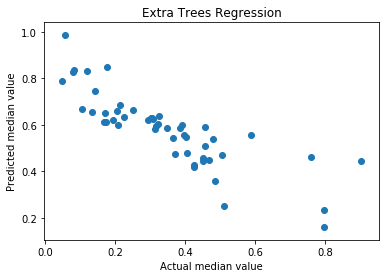

In [146]:
# Extra Trees Regressor - Approach 2

# Step 1: fit model
extratrees = ExtraTreesRegressor(n_estimators=100, criterion='mse', max_features=10, bootstrap=False, 
                                 n_jobs=-1, random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_extratrees = extratrees.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_extratrees)
plt.title("Extra Trees Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()

**Figure 24: Extra Trees regression on Box Cox scaled data: actual versus predicted values**

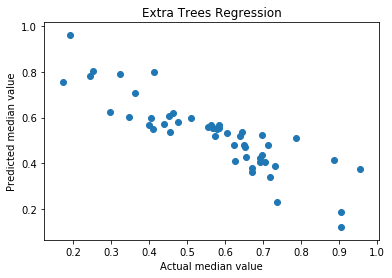

In [80]:
# Extra Trees Regressor - Approach 3

# Step 1: fit model
extratrees = ExtraTreesRegressor(n_estimators=100, criterion='mse', max_features=10, bootstrap=False, 
                                 n_jobs=-1, random_state=RANDOM_SEED).fit(X_train, y_train)

# Step 2: predict values
y_test_predict_extratrees = extratrees.predict(X_test)

# Create scatter plot of actual versus predicted median home values
plt.scatter(X_test[:,-1], y_test_predict_extratrees)
plt.title("Extra Trees Regression")
plt.xlabel("Actual median value")
plt.ylabel("Predicted median value")
plt.show()